In [ ]:
import zipfile

with zipfile.ZipFile("/content/data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data")

print("✅ Đã giải nén dữ liệu")


✅ Đã giải nén dữ liệu


In [ ]:
import torch, os
from torchvision import transforms, datasets
from torch.utils.data import ConcatDataset, Subset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

# Tiền xử lý gốc
transform_base = transforms.Compose([
    transforms.Resize((224,224)),#Chuẩn hóa kích thước ảnh đầu vào
    transforms.Grayscale(num_output_channels=3),#RGB 3 kênh
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)# chuẩn hóa giá trị pixel
])

# Augment 1
transform_aug1 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),#tăng độ đa dạng dữ liệu gương mặt
    transforms.RandomAffine(degrees=15, translate=(0.1,0.1)),# tạo sự biến dạng nhỏ (xoay, dịch chuyển), giúp mô hình học đặc trưng bền vững hơn với sự thay đổi tư thế
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Augment 2
transform_aug2 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),#điều chỉnh độ sáng/độ tương phản ngẫu nhiên
    transforms.RandomRotation(10),#xoay ảnh nhẹ
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load ảnh
ds_base = datasets.ImageFolder("/content/data/train", transform=transform_base)
ds_aug1 = datasets.ImageFolder("/content/data/train", transform=transform_aug1)
ds_aug2 = datasets.ImageFolder("/content/data/train", transform=transform_aug2)
ds_all  = ConcatDataset([ds_base, ds_aug1, ds_aug2])#Kết hợp 3 bộ dữ liệu (gốc + 2 augment)

# Chia tầng
targets = np.array([ds_base.targets[i % len(ds_base)] for i in range(len(ds_all))])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)#dùng để chia giữ nguyên tỉ lệ cảm xúc (số lượng mỗi lớp nhãn).
for train_idx, val_idx in sss.split(np.zeros(len(targets)), targets):
    train_ds = Subset(ds_all, train_idx)
    val_ds   = Subset(ds_all, val_idx)

test_ds = datasets.ImageFolder("/content/data/test", transform=transform_base)

# Tạo DataLoader
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

class_names = ds_base.classes
print("📊 Train:", len(train_ds), "| Val:", len(val_ds), "| Test:", len(test_ds))


📊 Train: 68901 | Val: 17226 | Test: 7178


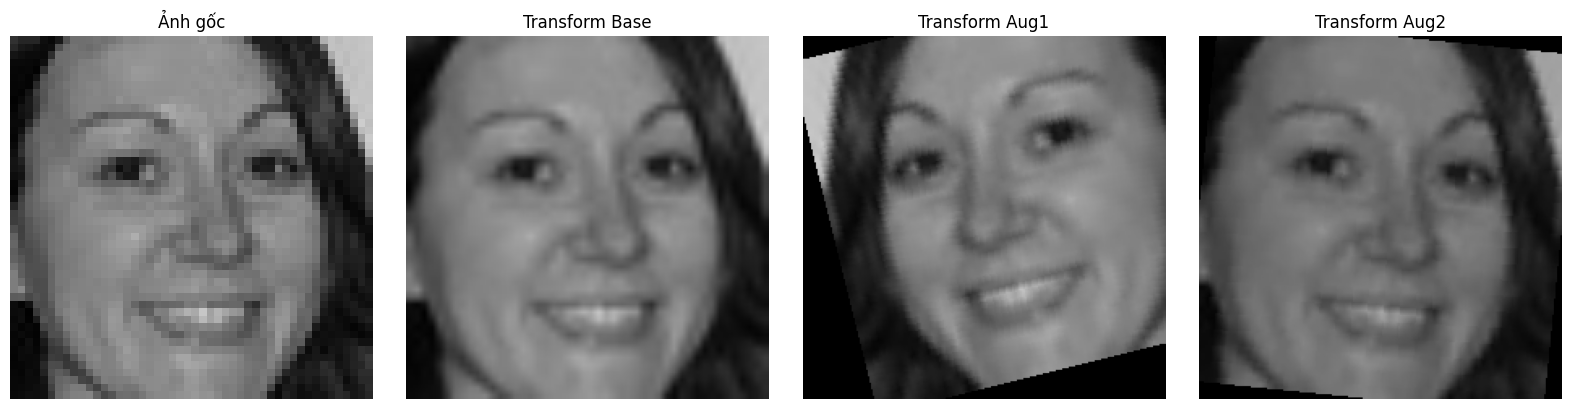

In [ ]:
#demo transform_base
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

# ===== Lấy 1 ảnh gốc =====
img_path = "/content/data/train/happy"  # Thay 'happy' nếu cần
img_file = os.listdir(img_path)[0]
img_orig = Image.open(os.path.join(img_path, img_file)).convert("RGB")

# ===== Các Transform =====
transform_base = transforms.Compose([
    transforms.Resize((224,224)),                        # 🌟 Bước 1: Resize ảnh về kích thước 224x224
    transforms.Grayscale(num_output_channels=3),         # 🌟 Bước 2: Chuyển sang ảnh xám (3 kênh để phù hợp mô hình pretrained)
    transforms.ToTensor(),                               # 🌟 Bước 3: Chuyển thành tensor
    transforms.Normalize([0.5]*3, [0.5]*3)                # 🌟 Bước 4: Chuẩn hóa về [-1, 1]
])

transform_aug1 = transforms.Compose([
    transforms.Resize((224,224)),                        # 🌟 Bước 1: Resize về 224x224
    transforms.RandomHorizontalFlip(p=1.0),              # ✅ Bước 2: Lật ngang ảnh (flip trái-phải)
    transforms.RandomAffine(degrees=15, translate=(0.1,0.1)),  # ✅ Bước 3: Xoay ngẫu nhiên ±15 độ, dịch chuyển ảnh 10%
    transforms.Grayscale(num_output_channels=3),         # 🌟 Bước 4: Chuyển sang ảnh xám
    transforms.ToTensor(),                               # 🌟 Bước 5: Chuyển sang tensor
    transforms.Normalize([0.5]*3, [0.5]*3)                # 🌟 Bước 6: Chuẩn hóa
])

transform_aug2 = transforms.Compose([
    transforms.Resize((224,224)),                        # 🌟 Bước 1: Resize về 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2),# ✅ Bước 2: Làm sáng/tối và thay đổi độ tương phản ngẫu nhiên
    transforms.RandomRotation(10),                       # ✅ Bước 3: Xoay ảnh ngẫu nhiên ±10 độ
    transforms.Grayscale(num_output_channels=3),         # 🌟 Bước 4: Ảnh xám
    transforms.ToTensor(),                               # 🌟 Bước 5: Tensor
    transforms.Normalize([0.5]*3, [0.5]*3)                # 🌟 Bước 6: Normalize
])


# ===== Hàm đảo Normalize để hiển thị =====
def denormalize(tensor):
    tensor = tensor.clone()
    for t in tensor:
        t.mul_(0.5).add_(0.5)
    return tensor

# ===== Áp dụng các biến đổi =====
img_base = denormalize(transform_base(img_orig))
img_aug1 = denormalize(transform_aug1(img_orig))
img_aug2 = denormalize(transform_aug2(img_orig))

# ===== Hiển thị theo lưới =====
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(img_orig)
axs[0].set_title("Ảnh gốc")
axs[0].axis("off")

axs[1].imshow(img_base.permute(1, 2, 0).numpy())
axs[1].set_title("Transform Base")
axs[1].axis("off")

axs[2].imshow(img_aug1.permute(1, 2, 0).numpy())
axs[2].set_title("Transform Aug1")
axs[2].axis("off")

axs[3].imshow(img_aug2.permute(1, 2, 0).numpy())
axs[3].set_title("Transform Aug2")
axs[3].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
#DEMO CHIA TÂNG
import collections

def count_labels(dataset, name):
    targets = [dataset[i][1] for i in range(len(dataset))]
    counter = collections.Counter(targets)
    print(f"📊 Phân bố nhãn trong {name}:")
    for k, v in counter.items():
        print(f"  Lớp {k} ({class_names[k]}): {v} ảnh")
    print()

count_labels(train_ds, "Train")
count_labels(val_ds, "Validation")
count_labels(test_ds, "Test")



📊 Phân bố nhãn trong Train:
  Lớp 4 (neutral): 11916 ảnh
  Lớp 3 (happy): 17316 ảnh
  Lớp 0 (angry): 9588 ảnh
  Lớp 5 (sad): 11592 ảnh
  Lớp 2 (fear): 9833 ảnh
  Lớp 6 (surprise): 7610 ảnh
  Lớp 1 (disgust): 1046 ảnh

📊 Phân bố nhãn trong Validation:
  Lớp 2 (fear): 2458 ảnh
  Lớp 0 (angry): 2397 ảnh
  Lớp 4 (neutral): 2979 ảnh
  Lớp 3 (happy): 4329 ảnh
  Lớp 6 (surprise): 1903 ảnh
  Lớp 5 (sad): 2898 ảnh
  Lớp 1 (disgust): 262 ảnh

📊 Phân bố nhãn trong Test:
  Lớp 0 (angry): 958 ảnh
  Lớp 1 (disgust): 111 ảnh
  Lớp 2 (fear): 1024 ảnh
  Lớp 3 (happy): 1774 ảnh
  Lớp 4 (neutral): 1233 ảnh
  Lớp 5 (sad): 1247 ảnh
  Lớp 6 (surprise): 831 ảnh



In [ ]:
import torch.nn as nn
from torchvision.models import vgg16

def create_vgg(num_classes):
    model = vgg16(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = True
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

model = create_vgg(len(class_names))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 102MB/s]


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, num_epochs=30, lr=1e-4, patience=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience)

    train_accs, val_accs = [], []
    val_losses, train_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = correct = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            _, pred = torch.max(out, 1)
            correct += (pred == y).sum().item()
            running_loss += loss.item() * x.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval(); val_correct = val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                _, pred = torch.max(out, 1)
                val_correct += (pred == y).sum().item()
                val_loss += loss.item() * x.size(0)

        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss / len(val_loader.dataset))
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        print(f"📍 Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f} | Train Loss: {train_loss:.4f} | Val Loss: {val_losses[-1]:.4f}")

    return model, train_accs, val_accs, train_losses, val_losses


In [ ]:
model, train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, num_epochs=10)
torch.save(model.state_dict(), "/content/vgg16_ep10.pth")
print("✅ Đã lưu mô hình sau 10 epoch")


📍 Epoch 1/10 | Train Acc: 0.58 | Val Acc: 0.66 | Train Loss: 1.1156 | Val Loss: 0.9155
📍 Epoch 2/10 | Train Acc: 0.70 | Val Acc: 0.73 | Train Loss: 0.8050 | Val Loss: 0.7492
📍 Epoch 3/10 | Train Acc: 0.78 | Val Acc: 0.77 | Train Loss: 0.6034 | Val Loss: 0.6312
📍 Epoch 4/10 | Train Acc: 0.84 | Val Acc: 0.82 | Train Loss: 0.4500 | Val Loss: 0.5271
📍 Epoch 5/10 | Train Acc: 0.88 | Val Acc: 0.85 | Train Loss: 0.3482 | Val Loss: 0.4673
📍 Epoch 6/10 | Train Acc: 0.90 | Val Acc: 0.86 | Train Loss: 0.2861 | Val Loss: 0.4293
📍 Epoch 7/10 | Train Acc: 0.92 | Val Acc: 0.87 | Train Loss: 0.2481 | Val Loss: 0.4093
📍 Epoch 8/10 | Train Acc: 0.93 | Val Acc: 0.88 | Train Loss: 0.2198 | Val Loss: 0.4040
📍 Epoch 9/10 | Train Acc: 0.93 | Val Acc: 0.89 | Train Loss: 0.2044 | Val Loss: 0.3696
📍 Epoch 10/10 | Train Acc: 0.94 | Val Acc: 0.89 | Train Loss: 0.1860 | Val Loss: 0.3917
✅ Đã lưu mô hình sau 10 epoch


<ipython-input-8-3792849613>:16: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-3792849613>:16: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


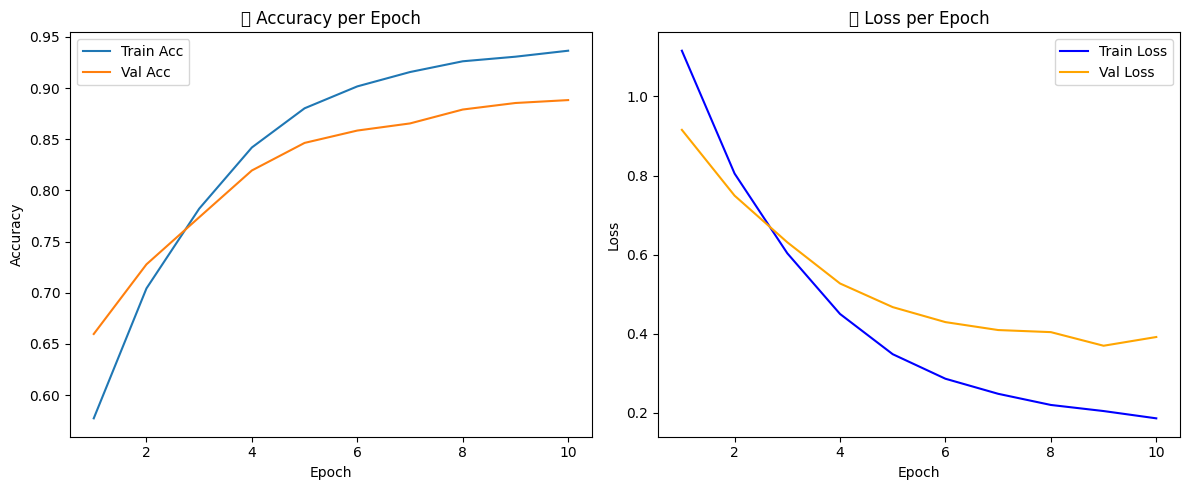

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc)+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.title("🎯 Accuracy per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_loss, label="Train Loss", color='blue')
plt.plot(epochs, val_loss, label="Val Loss", color='orange')
plt.title("📉 Loss per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.tight_layout()
plt.show()


📋 Classification Report
              precision    recall  f1-score   support

       angry       0.66      0.58      0.62       958
     disgust       0.79      0.63      0.70       111
        fear       0.59      0.53      0.56      1024
       happy       0.85      0.90      0.87      1774
     neutral       0.67      0.66      0.66      1233
         sad       0.55      0.61      0.58      1247
    surprise       0.80      0.81      0.80       831

    accuracy                           0.70      7178
   macro avg       0.70      0.67      0.69      7178
weighted avg       0.70      0.70      0.70      7178



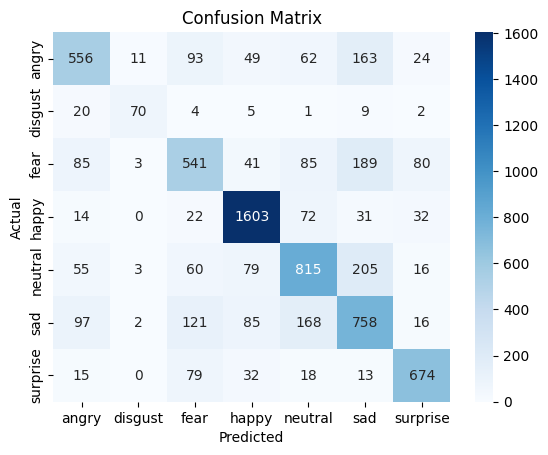

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, test_loader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device); model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            out = model(x)
            _, pred = torch.max(out, 1)
            y_true += y.tolist()
            y_pred += pred.cpu().tolist()

    print("📋 Classification Report")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_loader, class_names)


In [ ]:
# %%
# Hiển thị một số ảnh test cùng với dự đoán
def show_predictions_per_class(model, test_loader, class_names, max_per_class=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Dictionary để lưu ảnh theo từng cảm xúc thật
    from collections import defaultdict
    images_to_show = defaultdict(list)

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            out = model(x)
            _, preds = torch.max(out, 1)

            for img_tensor, true_idx, pred_idx in zip(x.cpu(), y, preds.cpu()):
                if len(images_to_show[true_idx.item()]) < max_per_class:
                    images_to_show[true_idx.item()].append((img_tensor.cpu(), pred_idx.item()))

    # Hiển thị ảnh
    for emotion_idx in sorted(images_to_show.keys()):
        imgs = images_to_show[emotion_idx]
        if imgs:
            plt.figure(figsize=(12, 2))
            for i, (img_tensor, pred_idx) in enumerate(imgs):
                img = img_tensor.permute(1, 2, 0).numpy()
                img = (img - img.min()) / (img.max() - img.min())  # normalize về [0, 1]

                plt.subplot(1, len(imgs), i + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Pred: {class_names[pred_idx]}")
            plt.suptitle(f"True Emotion: {class_names[emotion_idx]}", y=1.05)
            plt.show()


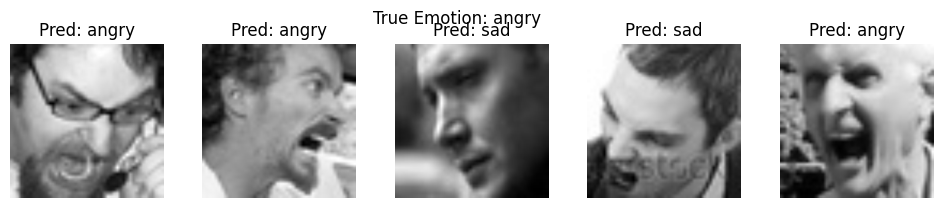

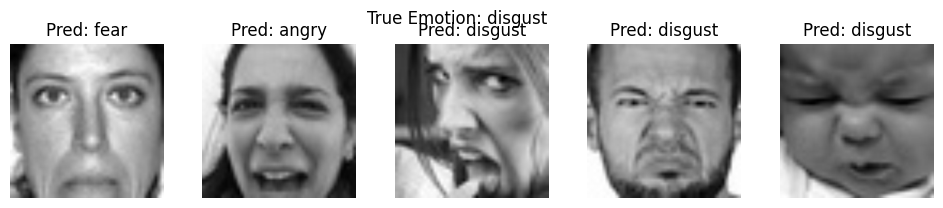

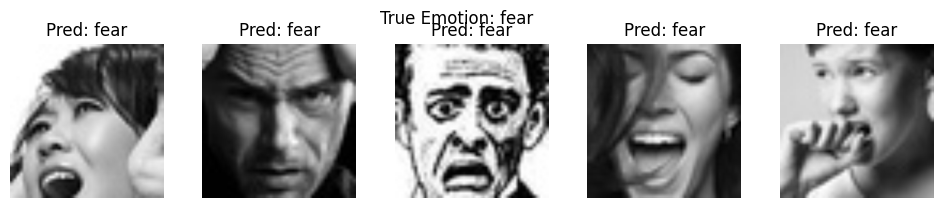

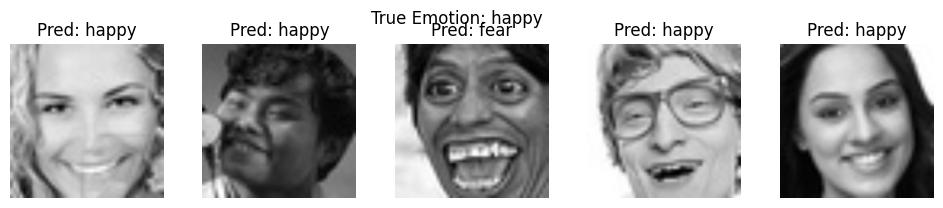

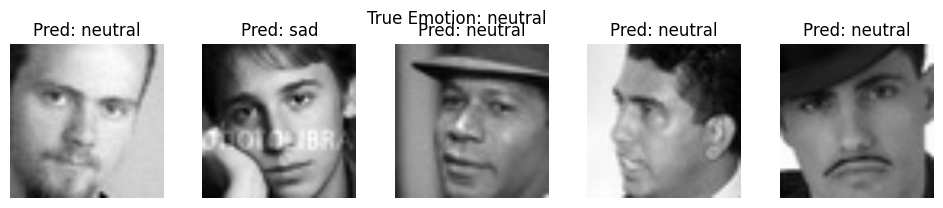

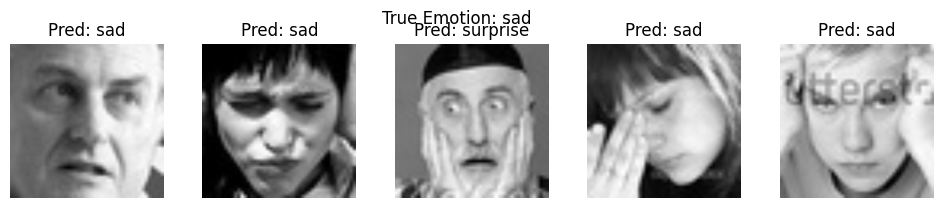

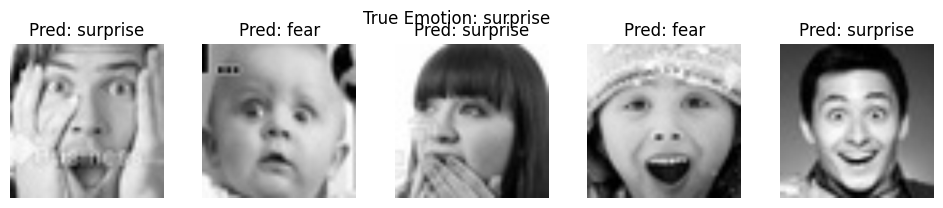

In [ ]:
show_predictions_per_class(model, test_loader, class_names)
